In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN
import shap
import keras_tuner as kt
from keras_tuner.engine.tuner import Tuner


import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Masking,
    LSTM,
    Dense,
    Dropout,
    Concatenate
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_tuner import Objective
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    fbeta_score,
    cohen_kappa_score,
    roc_curve,
    auc,
    precision_recall_curve
)
# Constants
FILL_VALUE = -999
RANDOM_STATE = 42
EMB_DIM = 16       # dimension for code embeddings
CODE_LSTM_UNITS = 32
NUM_LSTM_UNITS = 32
MAX_EPOCHS = 20
BATCH_SIZE = 32

## Evaluation function

In [ ]:

def evaluate_model(model, X_test_tuple, y_test, model_name="Model", save_fig=False):
    X_code_t, X_num_t = X_test_tuple
    # Predict probabilities & labels
    y_proba = model.predict([X_code_t, X_num_t]).ravel()
    y_pred = (y_proba > 0.5).astype(int)

    # Compute metrics
    cm = confusion_matrix(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    kappa = cohen_kappa_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

  
    print(f"Evaluation for {model_name}")
    print("-" * 40)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F2 Score: {f2:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("-" * 40)

    # Plotting
    plt.figure(figsize=(18, 5))

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"])
    plt.yticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"], rotation=0)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    if save_fig:
        plt.savefig(f"{model_name.replace(' ', '_')}_evaluation.pdf", format="pdf", bbox_inches="tight")
    plt.show()


In [5]:
df = pd.read_csv('C:/Users/u840716/Anna Thesis/Code Files -/final_data_DL_2.csv', parse_dates=['Date (s)'])

C:\Users\u840716\AppData\Local\Temp\3\ipykernel_13916\3777711561.py:1: DtypeWarning: Columns (22,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/u840716/Anna Thesis/Code Files -/final_data_DL_2.csv', parse_dates=['Date (s)'])


In [ ]:
# Label encoding for VT vs control
df['label'] = df['PatID'].apply(lambda x: 1 if str(x).startswith('VT') else 0)


# Integer-encode lab test codes for embedding
le_code = LabelEncoder()
df['Oms_Code_enc'] = le_code.fit_transform(df['Oms_Code']) + 1
num_codes = len(le_code.classes_) + 1  # +1 for reserved=0 pad

# Features
numeric_cols = ['Geslacht', 'Age_at_test', 'Uitslag']
code_col = 'Oms_Code_enc'

# Mask missing values
df[numeric_cols] = df[numeric_cols].fillna(FILL_VALUE)
df[code_col] = df[code_col].fillna(0).astype(int)

# Scaling numeric features
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [7]:
# Build time-series sequences per patient
X_num_list, X_code_list, y_list = [], [], []
for pid, grp in df.sort_values(['PatID', 'Date (s)']).groupby('PatID'):
    X_num_list.append(grp[numeric_cols].values)
    X_code_list.append(grp[code_col].values)
    y_list.append(grp['label'].iloc[0])

# Determine max sequence length
max_seq_len = max(len(seq) for seq in X_code_list)

# Pad sequences
X_num = pad_sequences(
    X_num_list,
    maxlen=max_seq_len,
    dtype='float32',
    padding='post',
    value=FILL_VALUE
)
X_code = pad_sequences(
    X_code_list,
    maxlen=max_seq_len,
    dtype='int32',
    padding='post',
    value=0
)
y = np.array(y_list)

In [ ]:
# Split into train/test
X_num_train, X_num_test, X_code_train, X_code_test, y_train, y_test = train_test_split(
    X_num, X_code, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

# SMOTE AND ADASYN

In [ ]:

# Flatten for resampling
n_num_feats = len(numeric_cols)
flat_num = X_num_train.reshape((X_num_train.shape[0], -1))
flat_code = X_code_train.reshape((X_code_train.shape[0], -1))
combined_flat = np.concatenate([flat_num, flat_code], axis=1)

smote = SMOTE(random_state=RANDOM_STATE)
comb_smote, y_smote = smote.fit_resample(combined_flat, y_train)

adasyn = ADASYN(random_state=RANDOM_STATE)
comb_adasyn, y_adasyn = adasyn.fit_resample(combined_flat, y_train)

In [ ]:
# Recover shapes
def unflatten(comb, n_feats):
    num_flat = comb[:, :n_feats]
    code_flat = comb[:, n_feats:]
    num_seq = num_flat.reshape((-1, max_seq_len, len(numeric_cols)))
    code_seq = code_flat.reshape((-1, max_seq_len))
    return num_seq, code_seq

X_num_smote, X_code_smote = unflatten(comb_smote, flat_num.shape[1])
X_num_adasyn, X_code_adasyn = unflatten(comb_adasyn, flat_num.shape[1])

# Compute class weights for balancing
class_weights_arr = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight = {i: w for i, w in enumerate(class_weights_arr)}

### Building model

In [ ]:
# Building dual-input LSTM model with embedding
def build_model():
    # Code branch
    code_in = Input(shape=(max_seq_len,), name='code_input')
    emb = Embedding(
        input_dim=num_codes,
        output_dim=EMB_DIM,
        mask_zero=True,
        name='code_emb'
    )(code_in)

    # Numeric branch
    num_in = Input(shape=(max_seq_len, n_num_feats), name='num_input')
    num_masked = Masking(mask_value=FILL_VALUE, name='num_mask')(num_in)

    # Combine
    merged = Concatenate(name='concat')([emb, num_masked])
    x = LSTM(64, name='lstm')(merged)
    x = Dropout(0.2, name='dropout')(x)
    out = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=[code_in, num_in], outputs=out)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    return model

In [ ]:
# Build dual-input LSTM model with separate LSTM branches

def build_model():
    # Code branch: Embedding -> LSTM
    code_in = Input(shape=(max_seq_len,), name='code_input')
    code_emb = Embedding(
        input_dim=num_codes,
        output_dim=EMB_DIM,
        mask_zero=True,
        name='code_emb'
    )(code_in)
    code_feat = LSTM(CODE_LSTM_UNITS, name='code_lstm')(code_emb)

    # Numeric branch: Masking -> LSTM
    num_in = Input(shape=(max_seq_len, n_num_feats), name='num_input')
    num_masked = Masking(mask_value=FILL_VALUE, name='num_mask')(num_in)
    num_feat = LSTM(NUM_LSTM_UNITS, name='num_lstm')(num_masked)

    # Combine and classify
    merged = Concatenate(name='feature_concat')([code_feat, num_feat])
    x = Dropout(0.2, name='dropout')(merged)
    out = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=[code_in, num_in], outputs=out)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    return model

### Applying oversampling techniques compared with baseline (no oversampling)

In [ ]:
# Train & evaluate baseline / SMOTE / ADASYN
strategies = {
    'baseline': ([X_code_train, X_num_train], y_train),
    'smote':    ([X_code_smote, X_num_smote], y_smote),
    'adasyn':   ([X_code_adasyn, X_num_adasyn], y_adasyn),
}

results = {}
for name, (X_tr, y_tr) in strategies.items():
    print(f"\n=== Training on {name} data ===")
    model = build_model()
    model.fit(
        X_tr,
        y_tr,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        class_weight=class_weight,
        verbose=2
    )

    # Predict and evaluate
    y_prob = model.predict([X_code_test, X_num_test]).ravel()
    y_pred = (y_prob > 0.5).astype(int)

    print(f"--- Results for {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    results[name] = model


=== Training on baseline data ===
Epoch 1/20
50/50 - 166s - 3s/step - AUC: 0.4607 - accuracy: 0.6065 - loss: 0.7367 - val_AUC: 0.4907 - val_accuracy: 0.7345 - val_loss: 0.6648
Epoch 2/20
50/50 - 178s - 4s/step - AUC: 0.5835 - accuracy: 0.6914 - loss: 0.6921 - val_AUC: 0.7909 - val_accuracy: 0.6893 - val_loss: 0.6383
Epoch 3/20
50/50 - 180s - 4s/step - AUC: 0.6947 - accuracy: 0.5965 - loss: 0.6457 - val_AUC: 0.9308 - val_accuracy: 0.6949 - val_loss: 0.6058
Epoch 4/20
50/50 - 181s - 4s/step - AUC: 0.7454 - accuracy: 0.6581 - loss: 0.6066 - val_AUC: 0.9025 - val_accuracy: 0.7514 - val_loss: 0.5635
Epoch 5/20
50/50 - 178s - 4s/step - AUC: 0.7533 - accuracy: 0.7058 - loss: 0.5972 - val_AUC: 0.8660 - val_accuracy: 0.8023 - val_loss: 0.4621
Epoch 6/20
50/50 - 182s - 4s/step - AUC: 0.7773 - accuracy: 0.7473 - loss: 0.5767 - val_AUC: 0.8908 - val_accuracy: 0.7006 - val_loss: 0.6020
Epoch 7/20
50/50 - 180s - 4s/step - AUC: 0.7843 - accuracy: 0.7153 - loss: 0.5683 - val_AUC: 0.9206 - val_accurac


=== Evaluation for LSTM (baseline) ===
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 609ms/step
Evaluation for LSTM (baseline)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80       425
           1       0.07      0.65      0.13        17

    accuracy                           0.67       442
   macro avg       0.53      0.66      0.46       442
weighted avg       0.94      0.67      0.77       442

F2 Score: 0.2523
Cohen’s Kappa: 0.0673
ROC AUC Score: 0.6600
----------------------------------------


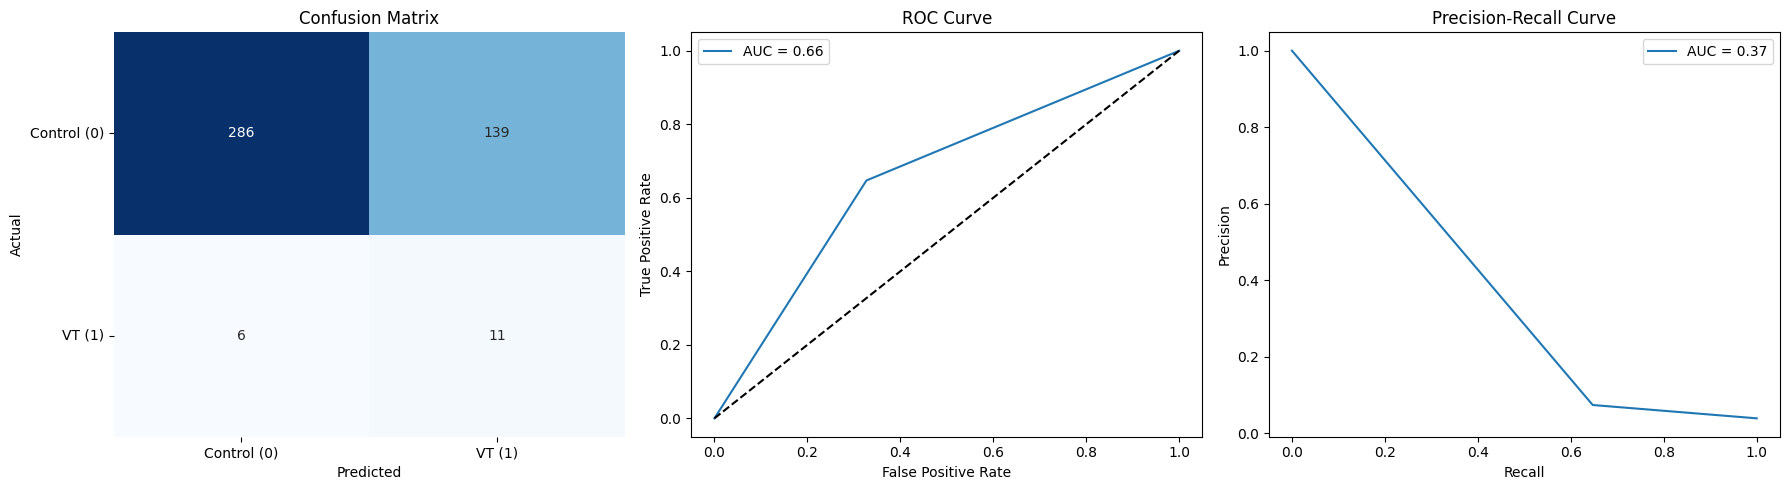


=== Evaluation for LSTM (smote) ===
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 538ms/step
Evaluation for LSTM (smote)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79       425
           1       0.07      0.65      0.13        17

    accuracy                           0.66       442
   macro avg       0.52      0.65      0.46       442
weighted avg       0.94      0.66      0.76       442

F2 Score: 0.2444
Cohen’s Kappa: 0.0613
ROC AUC Score: 0.6518
----------------------------------------


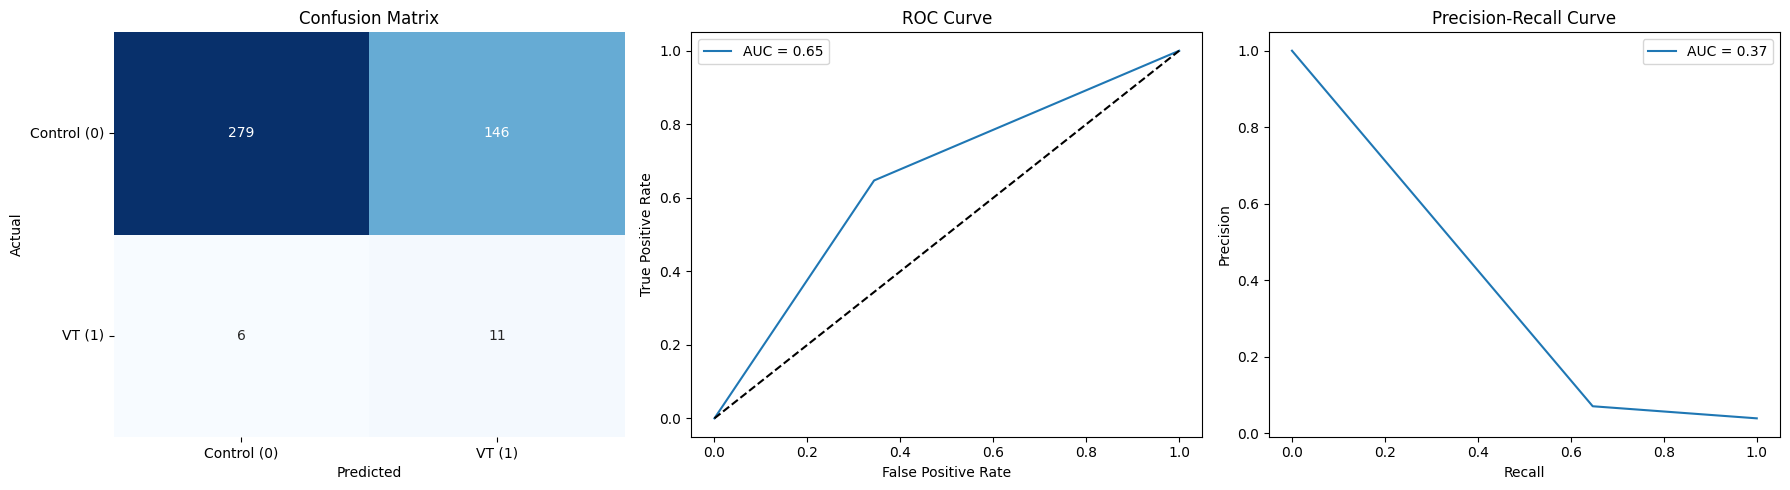


=== Evaluation for LSTM (adasyn) ===
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 557ms/step
Evaluation for LSTM (adasyn)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       425
           1       0.06      0.59      0.11        17

    accuracy                           0.65       442
   macro avg       0.52      0.62      0.45       442
weighted avg       0.94      0.65      0.76       442

F2 Score: 0.2212
Cohen’s Kappa: 0.0482
ROC AUC Score: 0.6200
----------------------------------------


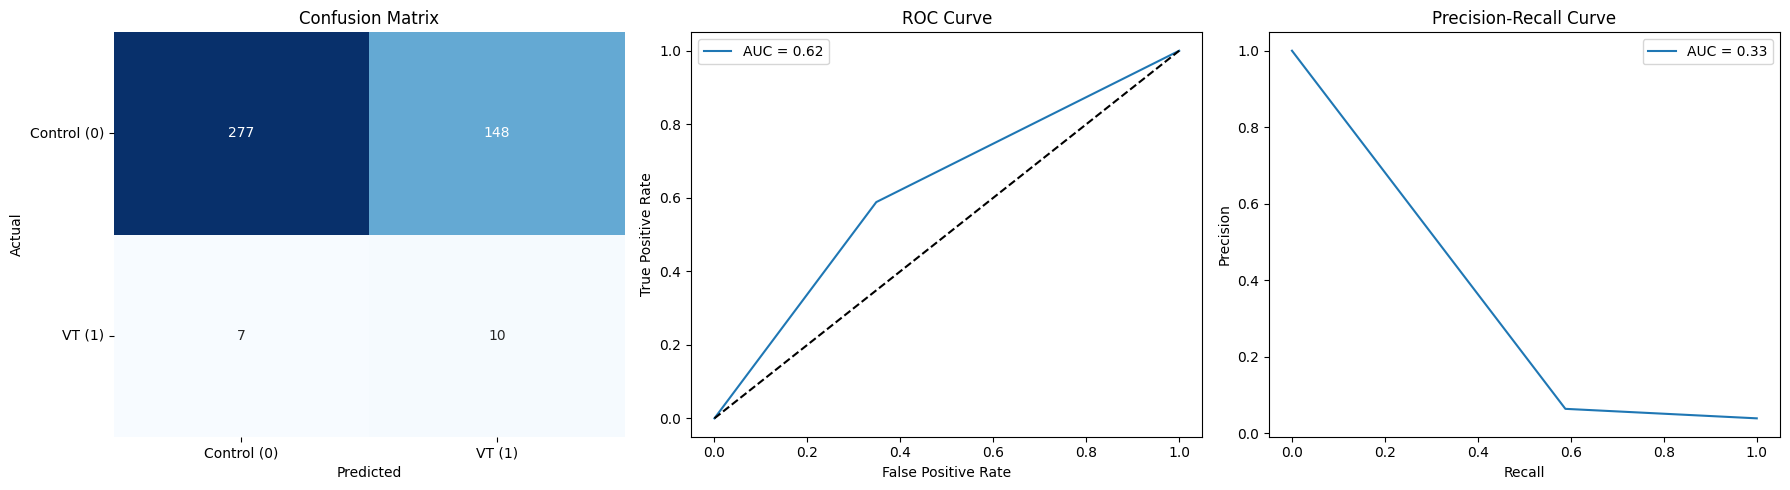

In [12]:
for name, model in results.items():
    # Monkey‐patch keras model for sklearn‐style API
    orig_predict = model.predict
    def predict_proba(X_list, orig_pred=orig_predict):
        p1 = orig_pred(X_list).ravel()
        return np.vstack([1 - p1, p1]).T
    def predict(X_list, orig_pred=orig_predict):
        return (orig_pred(X_list).ravel() > 0.5).astype(int)

    model.predict_proba = predict_proba
    model.predict       = predict

    # Evaluate
    print(f"\n=== Evaluation for LSTM ({name}) ===")
    evaluate_model(
        model,
        [X_code_test, X_num_test],
        y_test,
        model_name=f"LSTM ({name})",
        save_fig=True
    )


=== Evaluation for LSTM (smote) ===
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Evaluation for LSTM (smote)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.79       425
           1       0.08      0.71      0.14        17

    accuracy                           0.66       442
   macro avg       0.53      0.68      0.46       442
weighted avg       0.95      0.66      0.76       442

F2 Score: 0.2643
Cohen’s Kappa: 0.0719
ROC AUC Score: 0.6800
----------------------------------------


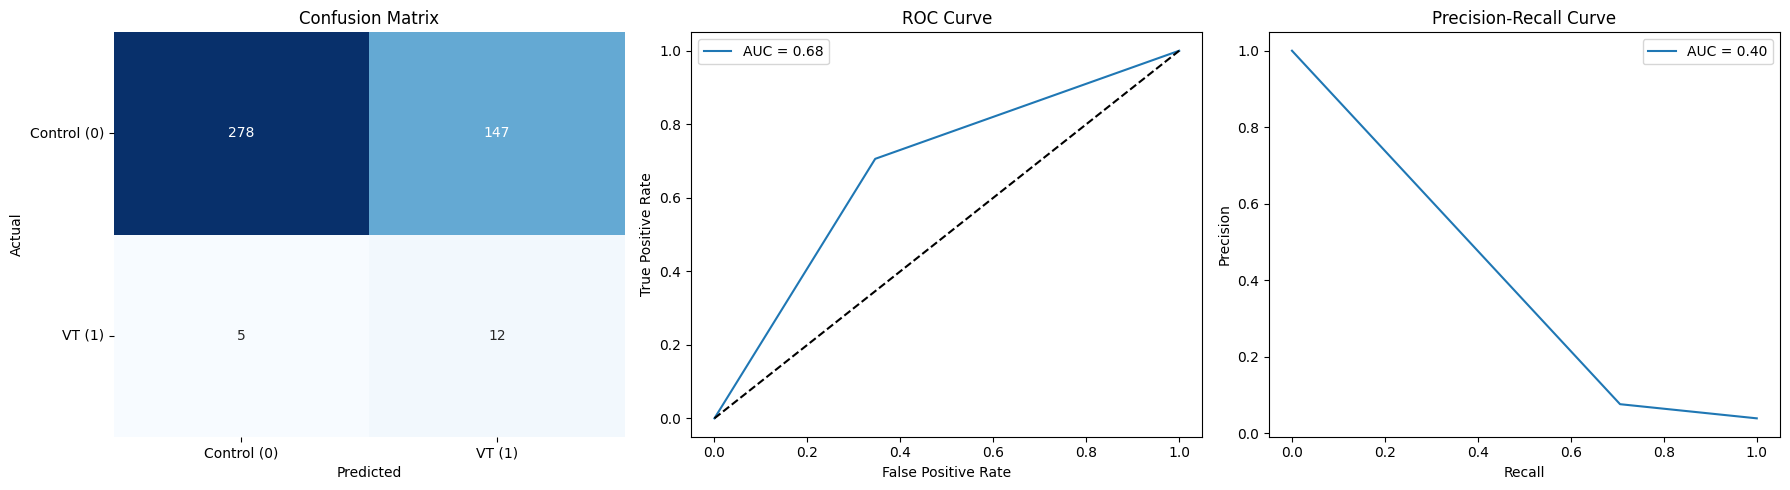

In [ ]:
# Evaluate best performing LSTM model
for name, model in results.items():
    print(f"\n=== Evaluation for LSTM ({name}) ===")

    # Monkey-patch the Keras model to have sklearn-like interface
    orig_predict = model.predict
    def predict_proba(X_list, orig_pred=orig_predict):
        p1 = orig_pred(X_list).ravel()
        return np.vstack([1 - p1, p1]).T
    def predict(X_list, orig_pred=orig_predict):
        return (orig_pred(X_list).ravel() > 0.5).astype(int)

    model.predict_proba = predict_proba
    model.predict = predict

    # Run evaluation
    evaluate_model(
        model,
        [X_code_test, X_num_test],
        y_test,
        model_name=f"LSTM ({name})",
        save_fig=True
    )


Applying threshold tuning to try to improve

In [ ]:
strategies = {
    # 'baseline': ([X_code_train, X_num_train], y_train),
     'smote':    ([X_code_smote, X_num_smote], y_smote),
    #'adasyn':   ([X_code_adasyn, X_num_adasyn], y_adasyn),
}

results = {}
for name, (X_tr, y_tr) in strategies.items():
    print(f"\n Training on {name} data ")
    model = build_model()
    model.fit(
        X_tr,
        y_tr,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        class_weight=class_weight,
        verbose=2
    )

    # 1) Predict probabilities
    y_prob = model.predict([X_code_test, X_num_test]).ravel()

    # 2) Threshold tuning for max F2
    thresholds = np.linspace(0.01, 0.99, 99)
    f2_scores = [
        fbeta_score(y_test, (y_prob > t).astype(int), beta=2)
        for t in thresholds
    ]
    best_idx       = np.argmax(f2_scores)
    best_threshold = thresholds[best_idx]
    best_f2        = f2_scores[best_idx]
    print(f"Optimal threshold = {best_threshold:.2f} (F2 = {best_f2:.3f})")

    # 3) Apply tuned threshold
    y_pred = (y_prob > best_threshold).astype(int)

    # 4) Final metrics
    print(f" Results for {name} (threshold {best_threshold:.2f}) ---")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    results[name] = model


 Training on smote data 
Epoch 1/20
96/96 - 365s - 4s/step - AUC: 0.7284 - accuracy: 0.4696 - loss: 1.4398 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0300
Epoch 2/20
96/96 - 375s - 4s/step - AUC: 0.9715 - accuracy: 0.5769 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 3/20
96/96 - 353s - 4s/step - AUC: 0.9791 - accuracy: 0.7500 - loss: 0.4596 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0104
Epoch 4/20
96/96 - 375s - 4s/step - AUC: 0.9807 - accuracy: 0.8122 - loss: 0.4325 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 5/20
96/96 - 410s - 4s/step - AUC: 0.9827 - accuracy: 0.8079 - loss: 0.4129 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 6/20
96/96 - 358s - 4s/step - AUC: 0.9831 - accuracy: 0.8341 - loss: 0.4059 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 7/20
96/96 - 376s - 4s/step - AUC: 0.9837 - accuracy: 0.8233 - loss: 0.4023 - val_AUC: 0.000

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Evaluation for smote
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.79       425
           1       0.08      0.71      0.14        17

    accuracy                           0.66       442
   macro avg       0.53      0.68      0.46       442
weighted avg       0.95      0.66      0.76       442

F2 Score: 0.2643
Cohen’s Kappa: 0.0719
ROC AUC Score: 0.7002
----------------------------------------


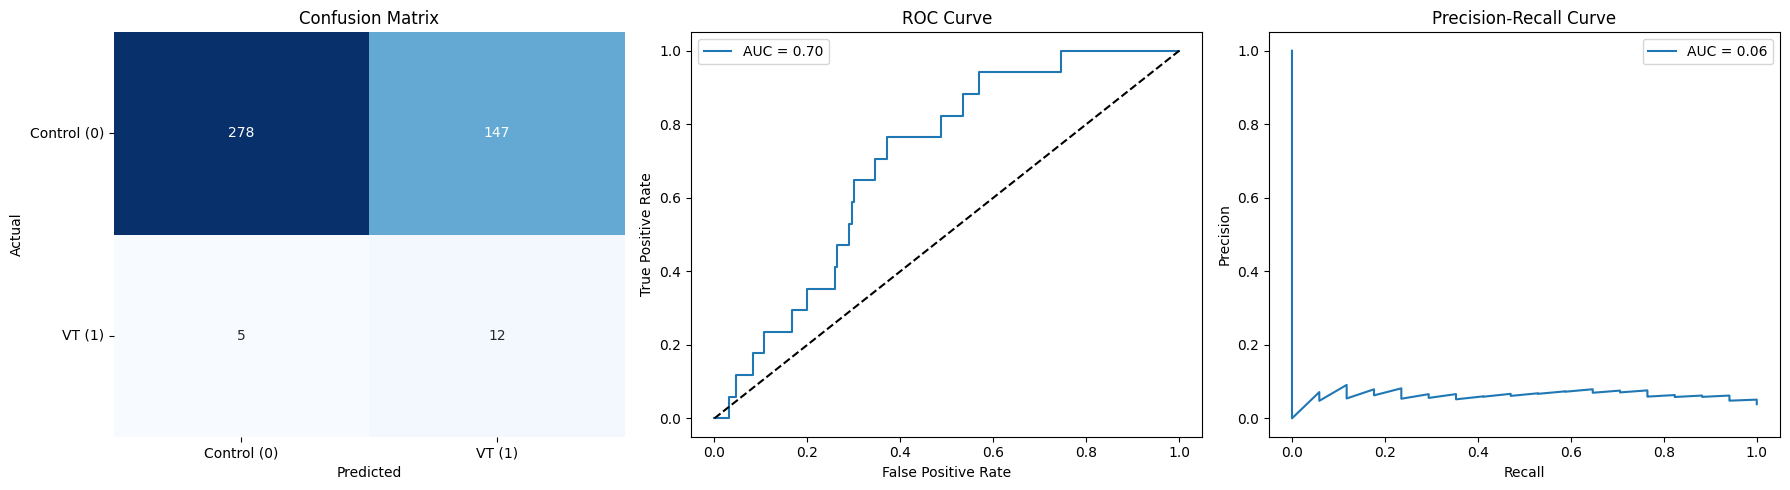

In [ ]:
    # Evaluate 
evaluate_model(
    model,
    (X_code_test, X_num_test),
    y_test,
    model_name=name,
    save_fig=True
)

This achieved the best result overall

Trying hyperparameter tuning for F2 score, with threshold tuning

In [25]:
class F2Tuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        model = self.hypermodel.build(trial.hyperparameters)

        # Get training and validation data from args/kwargs
        X_train, y_train = args
        validation_data = kwargs.get("validation_data")
        X_val, y_val = validation_data

        # Train the model for a few quick epochs
        model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=BATCH_SIZE,
            class_weight=class_weight,
            verbose=0,
            validation_data=validation_data
        )

        # Predict probabilities on validation set
        val_preds = model.predict(X_val).ravel()

        # Evaluate F2 across thresholds
        thresholds = np.linspace(0.01, 0.99, 99)
        f2_scores = [
            fbeta_score(y_val, (val_preds > t).astype(int), beta=2)
            for t in thresholds
        ]
        best_f2 = max(f2_scores)

        # Report best F2 to tuner
        self.oracle.update_trial(trial.trial_id, {'val_f2': best_f2})

        # Prevent NotImplementedError
        self.save_model(trial.trial_id, model)

    def save_model(self, trial_id, model, step=0):
        # Overriding this to avoid error
        pass


In [26]:
# Re-split the SMOTE training set
X_code_train_hp, X_code_val_hp, X_num_train_hp, X_num_val_hp, y_train_hp, y_val_hp = train_test_split(
    X_code_smote, X_num_smote, y_smote,
    test_size=0.2,
    stratify=y_smote,
    random_state=RANDOM_STATE
)

'''# Custom F2-scoring tuner objective
class F2Tuner(kt.engine.tuner.Tuner):
    def run_trial(self, trial, *args, **kwargs):
        model = self.hypermodel.build(trial.hyperparameters)

        # Train for fewer epochs to save time
        model.fit(*args, epochs=5, batch_size=BATCH_SIZE, class_weight=class_weight, verbose=0)

        # Predict on val set and find best F2 threshold
        val_preds = model.predict([X_code_val_hp, X_num_val_hp]).ravel()
        thresholds = np.linspace(0.01, 0.99, 99)
        f2s = [fbeta_score(y_val_hp, (val_preds > t).astype(int), beta=2) for t in thresholds]
        best_f2 = max(f2s)

        self.oracle.update_trial(trial.trial_id, {'val_f2': best_f2})
        self.save_model(trial.trial_id, model)
'''
# Model builder
def tuner_build_model(hp):
    cu = hp.Int('code_lstm_units', 16, 64, step=16)
    nu = hp.Int('num_lstm_units', 16, 64, step=16)
    ed = hp.Choice('emb_dim', [8, 16, 32])
    dr = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    code_in = Input((max_seq_len,), name='code_in_hp')
    emb = Embedding(num_codes, ed, mask_zero=True)(code_in)
    code_feat = LSTM(cu)(emb)

    num_in = Input((max_seq_len, n_num_feats), name='num_in_hp')
    num_mask = Masking(mask_value=FILL_VALUE)(num_in)
    num_feat = LSTM(nu)(num_mask)

    x = Concatenate()([code_feat, num_feat])
    x = Dropout(dr)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model([code_in, num_in], out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy')
    return model

# Tuner
f2_tuner = F2Tuner(
    hypermodel=tuner_build_model,
    objective=Objective('val_f2', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='f2_tuner_dir',
    project_name='lstm_smote_f2'
)

f2_tuner.search(
    [X_code_train_hp, X_num_train_hp],
    y_train_hp,
    validation_data=([X_code_val_hp, X_num_val_hp], y_val_hp),
    verbose=2
)

# Retrieve best model
best_hp = f2_tuner.get_best_hyperparameters(1)[0]
best_model_f2 = tuner_build_model(best_hp)
best_model_f2.fit(
    [X_code_smote, X_num_smote], y_smote,
    epochs=10,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    verbose=2
)


Trial 10 Complete [00h 29m 52s]
val_f2: 0.9612044006948466

Best val_f2 So Far: 0.9752504419563937
Total elapsed time: 08h 31m 04s
Epoch 1/10
107/107 - 758s - 7s/step - loss: 1.7240
Epoch 2/10
107/107 - 805s - 8s/step - loss: 0.7622
Epoch 3/10
107/107 - 761s - 7s/step - loss: 0.4638
Epoch 4/10
107/107 - 760s - 7s/step - loss: 0.4026
Epoch 5/10
107/107 - 803s - 8s/step - loss: 0.3774
Epoch 6/10
107/107 - 759s - 7s/step - loss: 0.3642
Epoch 7/10
107/107 - 802s - 7s/step - loss: 0.3576
Epoch 8/10
107/107 - 802s - 7s/step - loss: 0.3457
Epoch 9/10
107/107 - 759s - 7s/step - loss: 0.3550
Epoch 10/10
107/107 - 760s - 7s/step - loss: 0.3412


14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Evaluation for SMOTE_Tuned+Threshold_Tuning
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       425
           1       0.07      0.59      0.12        17

    accuracy                           0.68       442
   macro avg       0.52      0.63      0.46       442
weighted avg       0.94      0.68      0.78       442

F2 Score: 0.2336
Cohen’s Kappa: 0.0578
ROC AUC Score: 0.6287
----------------------------------------


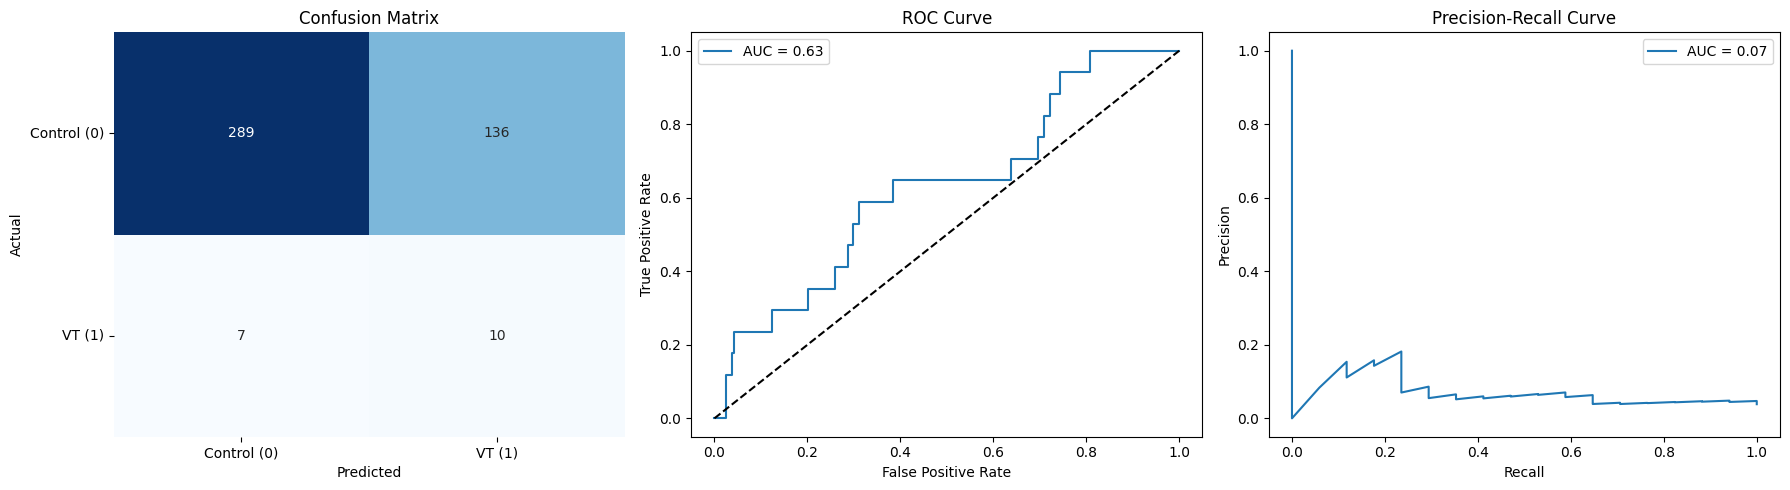

In [27]:
# final evaluation on true test set
evaluate_model(
    best_model_f2,
    (X_code_test, X_num_test),
    y_test,
    model_name='SMOTE_Tuned+Threshold_Tuning'
)

Second attempt at hyperparameter tuning (not good)

In [17]:
# 7. Hyperparameter Tuning on ADASYN (with proper val split)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt

# carve out a validation set from your ADASYN training:
X_code_train_hp, X_code_val_hp, X_num_train_hp, X_num_val_hp, y_train_hp, y_val_hp = train_test_split(
    X_code_smote, X_num_smote, y_smote,
    test_size=0.2,
    stratify=y_smote,
    random_state=RANDOM_STATE
)

# tuner builder (must match your final model architecture)
def tuner_build_model(hp):
    cu = hp.Int('code_lstm_units', 16, 64, step=16)
    nu = hp.Int('num_lstm_units', 16, 64, step=16)
    ed = hp.Choice('emb_dim', [8, 16, 32])
    dr = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    # code branch
    code_in = Input((max_seq_len,), name='code_in_hp')
    emb    = Embedding(num_codes, ed, mask_zero=True)(code_in)
    code_feat = LSTM(cu)(emb)

    # numeric branch
    num_in   = Input((max_seq_len, n_num_feats), name='num_in_hp')
    num_mask = Masking(mask_value=FILL_VALUE)(num_in)
    num_feat = LSTM(nu)(num_mask)

    # merge & output
    x   = Concatenate()([code_feat, num_feat])
    x   = Dropout(dr)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model([code_in, num_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
    )
    return model

# set up RandomSearch
rtuner = kt.RandomSearch(
    tuner_build_model,
    objective='val_AUC',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='smote_tuning'
)

# run the search
rtuner.search(
    [X_code_train_hp, X_num_train_hp], y_train_hp,
    validation_data=([X_code_val_hp, X_num_val_hp], y_val_hp),
    epochs=5,
    class_weight=class_weight,
    batch_size=BATCH_SIZE,
    verbose=2
)

# build & retrain best model on *all* ADASYN data
best_hp = rtuner.get_best_hyperparameters(1)[0]
best_model_tuned = tuner_build_model(best_hp)
best_model_tuned.fit(
    [X_code_smote, X_num_smote], y_smote,
    epochs=10,
    class_weight=class_weight,
    batch_size=BATCH_SIZE,
    verbose=2
)

Trial 10 Complete [00h 36m 47s]
val_AUC: 0.9733000993728638

Best val_AUC So Far: 0.9897793531417847
Total elapsed time: 06h 24m 46s
Epoch 1/10
107/107 - 578s - 5s/step - AUC: 0.9629 - accuracy: 0.6375 - loss: 0.5650
Epoch 2/10
107/107 - 629s - 6s/step - AUC: 0.9838 - accuracy: 0.7892 - loss: 0.3959
Epoch 3/10
107/107 - 623s - 6s/step - AUC: 0.9858 - accuracy: 0.8213 - loss: 0.3785
Epoch 4/10
107/107 - 621s - 6s/step - AUC: 0.9858 - accuracy: 0.8165 - loss: 0.3751
Epoch 5/10
107/107 - 581s - 5s/step - AUC: 0.9885 - accuracy: 0.8357 - loss: 0.3327
Epoch 6/10
107/107 - 623s - 6s/step - AUC: 0.9857 - accuracy: 0.8195 - loss: 0.3773
Epoch 7/10
107/107 - 582s - 5s/step - AUC: 0.9858 - accuracy: 0.8054 - loss: 0.3767
Epoch 8/10
107/107 - 580s - 5s/step - AUC: 0.9874 - accuracy: 0.8392 - loss: 0.3488
Epoch 9/10
107/107 - 578s - 5s/step - AUC: 0.9880 - accuracy: 0.8640 - loss: 0.3413
Epoch 10/10
107/107 - 580s - 5s/step - AUC: 0.9891 - accuracy: 0.8357 - loss: 0.3311


14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
Evaluation for SMOTE_Tuned
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82       425
           1       0.07      0.59      0.13        17

    accuracy                           0.70       442
   macro avg       0.53      0.65      0.48       442
weighted avg       0.94      0.70      0.79       442

F2 Score: 0.2475
Cohen’s Kappa: 0.0689
ROC AUC Score: 0.7175
----------------------------------------


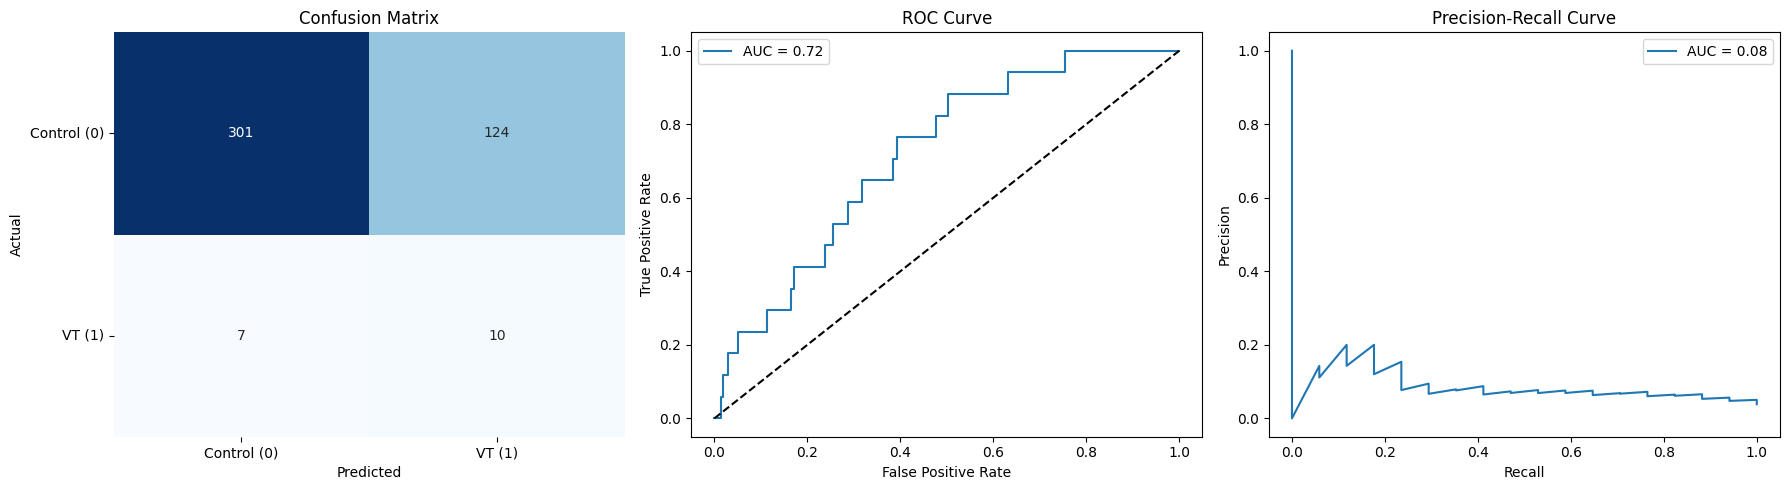

In [ ]:
# Final evaluation on test set
evaluate_model(
    best_model_tuned,
    (X_code_test, X_num_test),
    y_test,
    model_name='SMOTE_Tuned'
)
